In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import itertools
import dateutil.parser



# *Assessment Questions*
### 1. How many leaks are ongoing for every day in 2017?
### 2. What is total water use by day for the entire utility?
### 3. Which month had the highest aggregate volume of water lost to leaks?
### 4. As a percentage of total annual consumption, how much water is lost due to leaks for the entire utility by month?

## 1. How many leaks are ongoing for every day in 2017?

In [2]:
#load leak events
leaks = pd.read_csv('LeakEvents2017.csv')

In [3]:
#copy leak events into new dataframe to prevent alterations uneccessary for future use
day_grouped_leaks = leaks.copy()
#check for missing values in each column
print(day_grouped_leaks.isna().sum())
#see first rows of data to observe datatypes, necessary features
day_grouped_leaks.head()

,residence_id,start_interval_datetime,end_interval_datetime,leak_rate
0,2,2017-04-09 14:00:00.000,2017-04-13 21:00:00.000,100.0
1,2,2017-04-15 20:00:00.000,2017-04-19 18:00:00.000,100.0
2,2,2017-06-15 21:00:00.000,2017-06-21 19:00:00.000,100.0
3,4,2017-11-28 14:00:00.000,2017-12-01 18:00:00.000,100.0
4,6,2017-09-13 19:00:00.000,2017-09-19 10:00:00.000,300.0


In [65]:
def leaks_per_day(year, rows, day_grouped_leaks):
    leak_dates = []
    leak_vol = []
    
    #convert list of unique timestamps into datetime objects (.unique() converts to timestamp)
    start_dates = [dateutil.parser.parse(str(date)) for date in day_grouped_leaks.start_interval_datetime.unique()]
    end_dates = [dateutil.parser.parse(str(date)) for date in day_grouped_leaks.end_interval_datetime.unique()]
    #first leak's start date in 2017
    start_dates = [date for date in start_dates if date.year == year]
    first_day = min(start_dates)
    #leaks' end dates in 2017
    end_dates = [date for date in end_dates if date.year == year]
    last_day = max(end_dates)
    #determine dates during which each leak persisted
    for leak in range(rows):
        diff = (day_grouped_leaks.end_interval_datetime[leak] - day_grouped_leaks.start_interval_datetime[leak])
        leak_dates.append([day_grouped_leaks.start_interval_datetime[leak] + timedelta(days=leak_length) \
                            for leak_length in range(diff.days + 1)])
        leak_vol.append(day_grouped_leaks.leak_rate[leak] * diff.seconds//60)
    #flatten dates of each leak into all dates of all leaks
    leak_dates = pd.Series(list(itertools.chain.from_iterable(leak_dates)))
    #count number of leaks per day
    leak_date_counts = leak_dates.value_counts()
    #combine number of leaks per day with date indexing
    leak_dates = leak_date_counts.index
    leak_counts = pd.DataFrame(list(zip(leak_dates, leak_date_counts)), columns=['date', 'leak_count'])
    leak_counts.sort_values(by='date', ascending=True)
    
    return leak_counts, leak_vol

#number of leaks
num_leaks = day_grouped_leaks.shape[0]
#leak start and end dates converted to datetime objects
day_grouped_leaks.start_interval_datetime = pd.to_datetime(day_grouped_leaks.start_interval_datetime)
day_grouped_leaks.end_interval_datetime = pd.to_datetime(day_grouped_leaks.end_interval_datetime)
year = 2017
ongoing_leaks, leak_vol = leaks_per_day(year, num_leaks, day_grouped_leaks)
#include the total gallons lost in each leak
day_grouped_leaks['leak_vol'] = leak_vol

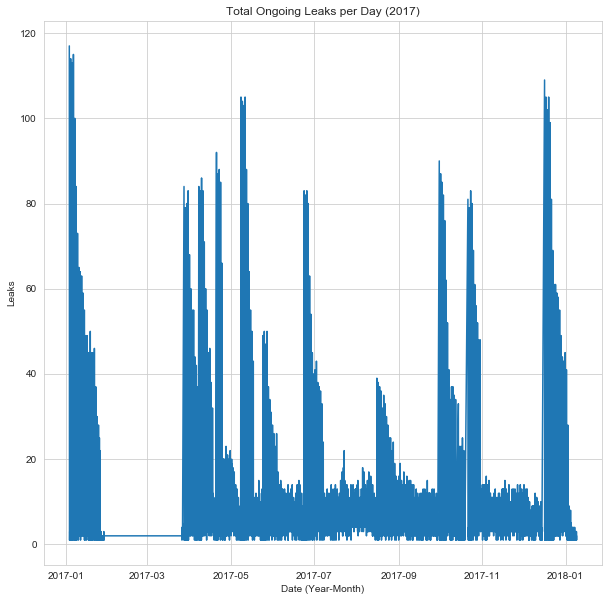

In [15]:
#plot timeseries number of leaks per day for 2017
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
sns.set_style('whitegrid')
sns.lineplot(data=ongoing_leaks, x='date', y='leak_count')
ax.set_xlabel('Date (Year-Month)')
ax.set_ylabel('Leaks')
ax.set_title('Total Ongoing Leaks per Day (2017)');

## 2. What is total water use by day for the entire utility?

In [6]:
#load data
hourly = pd.read_csv('HourlyIntervalData2017.csv')

In [7]:
#drop uneccesary data (no customer information necessary)
hourly_events = hourly.copy().drop('residence_id', axis=1)
#fill rows missing usage data with cannot achieve accurate usage with median usage value
hourly_events.dropna(subset=['gallons'], inplace = True)

In [8]:
def usage_per_day(events):
    #convert timestamp datapoint to datetime object
    events.read_datetime = pd.to_datetime(events.read_datetime)
    #drop time data because day of each point more relevant
    events['read_datetime'] = events["read_datetime"].apply( lambda events : 
    datetime(year=events.year, month=events.month, day=events.day))
    #sum usage by day
    events = events.groupby('read_datetime').sum()    

    return events

events = hourly_events.copy()
daily_usage = usage_per_day(events)

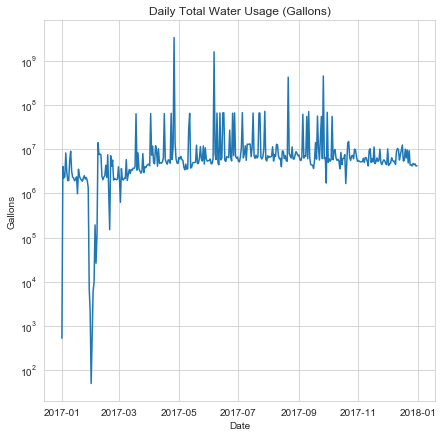

In [83]:
#plot timeseries usage (gallons) per day for all available time
fig = plt.figure(figsize=(7,7))
ax = fig.gca()
sns.set_style('whitegrid')
plt.yscale("log")
sns.lineplot(data=daily_usage, x=daily_usage.index, y='gallons')
ax.set_xlabel('Date')
ax.set_ylabel('Gallons')
ax.set_title('Daily Total Water Usage (Gallons)');

## 3. Which month had the highest aggregate volume of water lost to leaks?

In [43]:
#copy day_grouped_leaks in-case needed for further analysis
month_leaks = day_grouped_leaks.copy()
#index by starting date
month_leaks.set_index(month_leaks['start_interval_datetime'], inplace=True)
#group by by month and sum leak_vol for each month
month_leaks = month_leaks['leak_vol'].resample('M', how='sum')

/home/raghav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  This is separate from the ipykernel package so we can avoid doing imports until


count    1.200000e+01
mean     2.975830e+08
std      1.634692e+08
min      0.000000e+00
25%      1.816068e+08
50%      3.815809e+08
75%      4.040332e+08
max      4.961046e+08
Name: leak_vol, dtype: float64

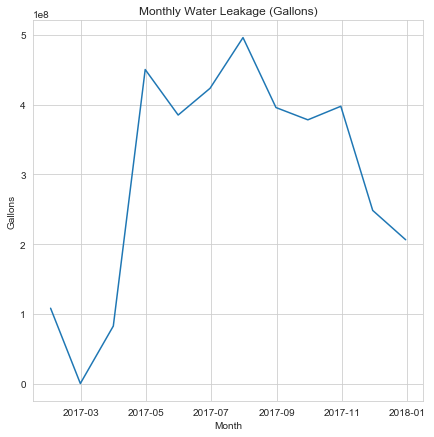

In [84]:
#plot timeseries leakge (gallons) per month for all available time
fig = plt.figure(figsize=(7,7))
ax = fig.gca()
sns.set_style('whitegrid')
sns.lineplot(data=month_leaks)
ax.set_xlabel('Month')
ax.set_ylabel('Gallons')
ax.set_title('Monthly Water Leakage (Gallons)');
month_leaks.describe()

## 4. As a percentage of total annual consumption, how much water is lost due to leaks for the entire utility by month?

9286803685.299992


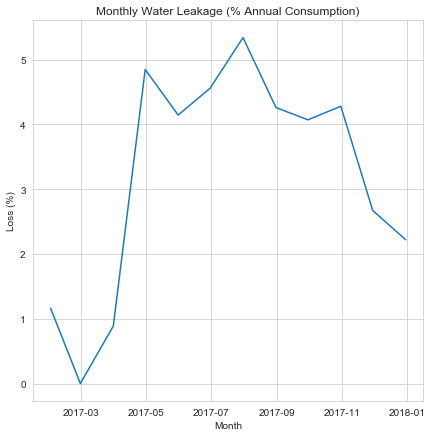

In [85]:
#calculate annual water consumption (gallons)
annual_consumption = daily_usage.gallons.sum()
#create Series of % loss relative to annual consumption
month_leaks.leak_pct = (month_leaks/annual_consumption) * 100

#plot timeseries loss (gallons leaked/annual consumption * 100%) per month for all available time
fig = plt.figure(figsize=(7,7))
ax = fig.gca()
sns.set_style('whitegrid')
sns.lineplot(data=month_leaks.leak_pct)
ax.set_xlabel('Month')
ax.set_ylabel('Loss (%)')
ax.set_title('Monthly Water Leakage (% Annual Consumption)');